# 01] Procesos MA (q)
    - En este notebook se simulan modelos de series de tiempo con procesos MA(q). La 
    finalidad es observar que para la evaluación de cada modelo es necesario observar diferentes funciones
    de autocorrelación.

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [35]:
# Total data points generated
T = 1500
# Sample size of simulated time series
n = 120
# Times the time series is simulated to evaluat AFs
N = 1000
# Lags to be calculated in ACF
nlags = 20
# Select order of the model
q = 2

### 01.1] Simulación de modelo MA
    - Se aborda primero debido a que es el modelo más sencilllo de todos, pues no existen restricciones sobre 
    su colección de parámetros. Se asume un modelo centrado en cero.

Text(0.5, 1.0, 'Simulation of MA(2)')

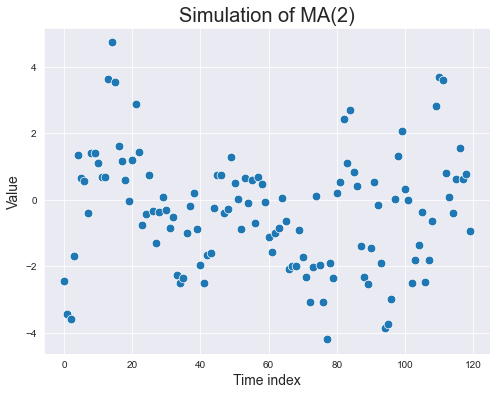

In [37]:
# Define function to generate MA time series
def MA(ma_q=q, ma_n=n):

    # Randomly generate values for the parameters
    theta = np.random.uniform(low=75, high=150, size=ma_q) / 100
    
    # Generate more entries if necessary
    ma_T = T if ma_n*2 < T else ma_n*2
    
    # Matrix to store results
    ma = np.zeros(ma_T)

    # Generate errors vector
    errors = np.random.normal(size=ma_T)

    # Start values are considered only e_t (error at time t)
    for i in range (q+1,ma_T):
        ma[i] = errors[i] + (errors[i-q:i] * theta).sum()

    # Obtain a sample of n consecutive data points (after index 100, used as start up values)
    start = int(np.random.uniform(low=100, high=(ma_T-ma_n), size=1)[0])
    ma = ma[start:start+ma_n]

    # Return simulated time series
    return ma

# Simulate one
ma_sample = MA(q, ma_n=n)

# Plot generated time series
time = [i for i in range(ma_sample.shape[0])]
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.scatterplot(x=time, y=ma_sample, s=75)

# Chart settings
plt.ylabel("Value", fontsize=14)
plt.xlabel("Time index", fontsize=14)
plt.title("Simulation of MA("+str(q)+")", fontsize=20)

### 01.2] ACF - Función de autocorrelación
    - Cuando se tiene una muestra y se quiere ajustar un modelo MA, se tiene que revisar el autocorrelograma
    para detectar hasta que lag se espera distinto de 0. Se tiene quer recordar que la teoría dice que para un
    modelo MA(q), ACF(i)=0 con i>q 

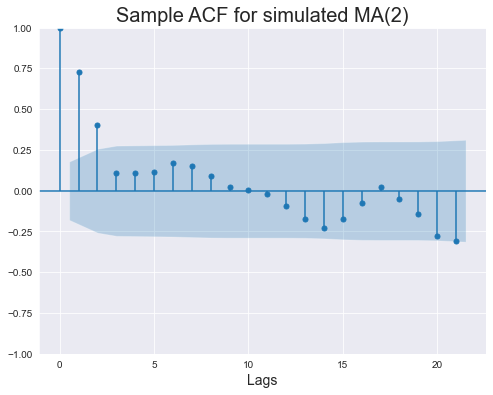

In [38]:
# Plot ACF for n/4 lags
fig, ax = plt.subplots(figsize=(8, 6))
plot_acf(ma_sample, ax=ax, adjusted=True)
plt.xlabel("Lags", fontsize=14)
plt.title("Sample ACF for simulated MA("+str(q)+")", fontsize=20)
plt.show()

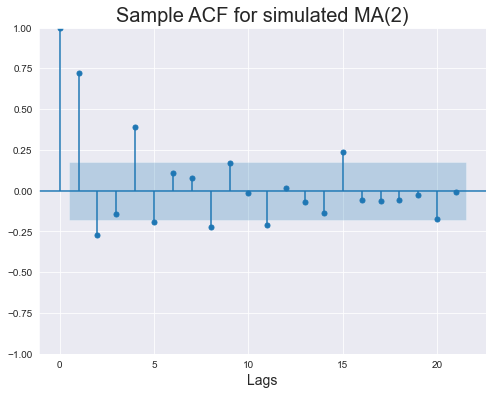

In [39]:
# Plot PACF for n/4 lags
fig, ax = plt.subplots(figsize=(8, 6))
plot_pacf(ma_sample, ax=ax, method="ywm")
plt.xlabel("Lags", fontsize=14)
plt.title("Sample ACF for simulated MA("+str(q)+")", fontsize=20)
plt.show()

### 01.3] Revisar funciones de autocorrelación
    - De acuerdo con la teoría y los supuestos hechos sobre los modelos MA, la ACF es distinta de 0 para 
    valores de tau menores e igual que q, después se vuelven 0 (simétricamente para valores negativos). Por lo 
    tanto, se realizan simulaciones para conoccer el comportamiento de estas gráficas

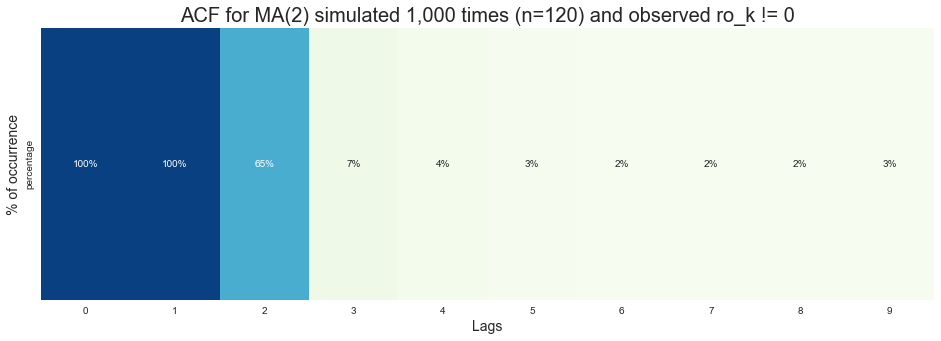

In [40]:
def not_zeros(nz_n=n, function="acf"):

    nz_nlags = nlags if nlags < nz_n/4 else int(nz_n/4)
    
    # Auxiliar matrix to store results
    not_zero_f = np.full((N, 1+nz_nlags), True)
    
    # Generate N samples (each size n) of a MA(q) model
    for k in range(1000):

        # Simulate time series
        ma_sample = MA(ma_q=q, ma_n=nz_n)

        # Compute ACF
        acf_sample = acf(ma_sample, adjusted=False, nlags=nz_nlags, qstat=False, fft=False, alpha=0.05,
                         bartlett_confint=True, missing="drop")

        # Compute PCAF if stated
        if function=="pacf":
            acf_sample = pacf(ma_sample, method= "ywmle", alpha=0.05)
        
        # Check if confidence interval contains 0
        temporal = acf_sample[1] > 0
        not_zero_f[k] = (temporal[:,0] == temporal[:,1])
        
    return not_zero_f

not_zero = not_zeros()

# Plot results
temporal = pd.DataFrame(columns=["percentage"], data=not_zero.sum(axis=0)/N)
plt.figure(figsize=(16, 5))
sns.heatmap(temporal.iloc[:10,:].T, fmt=".0%", annot=True, cbar=False, cmap="GnBu")
plt.xlabel("Lags", fontsize=14)
plt.ylabel("% of occurrence", fontsize=14)
plt.title("ACF for MA({}) simulated {:,} times (n={:,}) and observed ro_k != 0".format(q,N,n), fontsize=20)
plt.show()

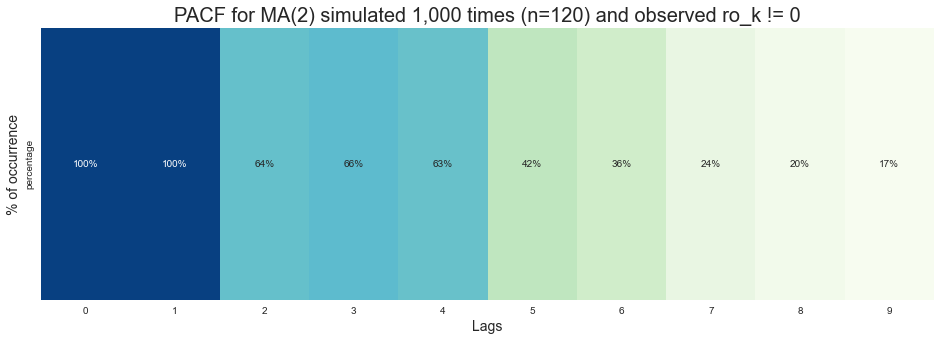

In [41]:
# Compute 
not_zero = not_zeros(function = "pacf")

# Plot results
temporal = pd.DataFrame(columns=["percentage"], data=not_zero.sum(axis=0)/N)
plt.figure(figsize=(16, 5))
sns.heatmap(temporal.iloc[:10,:].T, fmt=".0%", annot=True, cbar=False, cmap="GnBu")
plt.xlabel("Lags", fontsize=14)
plt.ylabel("% of occurrence", fontsize=14)
plt.title("PACF for MA({}) simulated {:,} times (n={:,}) and observed ro_k != 0".format(q,N,n), fontsize=20)
plt.show()

### 01.1.3] Efecto del tamaño de muestra en ACF
    - El tamaño de muestra en series de tiempo es un factor muy importante que tomar en cuenta, debido a que
    las funciones de autocorrelación son sensibles y podrían ser o no significativamente distintas que cero
    dependiendo del tamaño de muestra, a pesar de ser originalmente generados por un proceso distinto al que
    se observa.

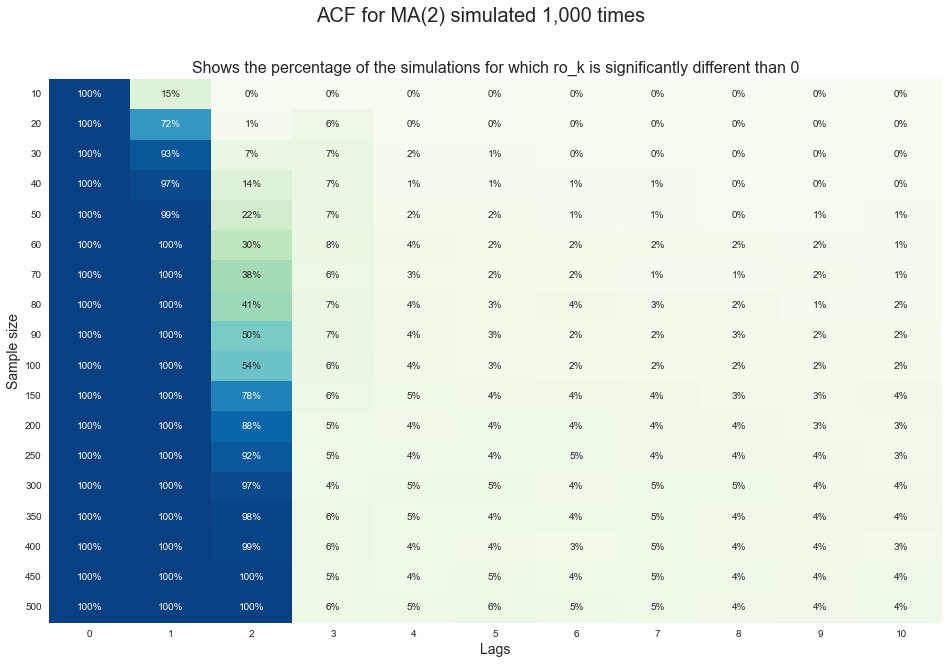

In [42]:
# Define AC funtion to be analyzed
ac_fun = "acf"

# Change order for MA model
# for q in range(1,2):    
#     print("q={}:".format(q))

# Define various sample sizes
n_sizes = [i for i in range(10,100,10)] + [i for i in range(100, 501, 50)]
# Used to store results
df_not_zero = pd.DataFrame(index=[i for i in range(nlags+1)])

# Run process for each sample size
for n_iter in n_sizes:

    # Calculate ACF and count the ones significantly different than zero ones
    temporal = not_zeros(nz_n=n_iter, function=ac_fun)

    # If n/4 is lower than nlags, complete with zeros
    temporal = temporal.sum(axis=0)/N
    if len(temporal) < nlags+1:
        temporal = np.append(temporal, [0 for i in range(nlags+1-len(temporal))])

    # Store results
    df_not_zero[n_iter] = temporal

# Create plot, save and show it
plt.figure(figsize=(16, 10))
sns.heatmap(df_not_zero.iloc[:11,:].T, fmt=".0%", annot=True, cbar=False, cmap="GnBu")
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Sample size", fontsize=14)
plt.yticks(rotation=0)
plt.suptitle("{} for MA({}) simulated {:,} times".format(ac_fun.upper(),q,N), fontsize=20)
plt.title("Shows the percentage of the simulations for which ro_k is significantly different than 0", fontsize=16)
plt.show()
#    plt.savefig("/Users/eduardo/Desktop/MA({}) - {}".format(q,ac_fun.upper()))